# NLP - Named Entity Recognition using RNNs.

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the applying Named Entity Recognition using RNNs on PyTorch.

## About Dataset

Link to dataset: https://www.clips.uantwerpen.be/conll2003/ner/  
Easy downloadable data: https://github.com/patverga/torch-ner-nlp-from-scratch/tree/master/data/conll2003 or https://github.com/davidsbatista/NER-datasets/tree/master/CONLL2003

 Named entities are phrases that contain the names of persons, organizations, locations, times, and quantities. Example:

    [ORG U.N. ] official [PER Ekeus ] heads for [LOC Baghdad ] . 
    
The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv('../../../data/nlp/ner/conll_ner.txt', sep=' ', skiprows = 1, index_col=False, names=['word', 'pos', 'syn', 'tag']) 

In [4]:
df.head()

,word,pos,syn,tag
0,EU,NNP,I-NP,I-ORG
1,rejects,VBZ,I-VP,O
2,German,JJ,I-NP,I-MISC
3,call,NN,I-NP,O
4,to,TO,I-VP,O


## Pre Processing

### Add sentence ID. 
Each full-stop signifies the end of a sentence.

In [5]:
df['sentence_id'] = np.nan
df = df[['sentence_id', 'word', 'pos', 'syn', 'tag']]

In [6]:
df['sentence_id'] = np.nan
df.iloc[0, 0] = 1
df.loc[df['word'] == '.', ['sentence_id']] = np.arange(1, len(df[df['word'] == '.'])+1)
df.fillna(method='bfill', inplace=True)
df = df.loc[:204543, :]
df.head()

,sentence_id,word,pos,syn,tag
0,1.0,EU,NNP,I-NP,I-ORG
1,1.0,rejects,VBZ,I-VP,O
2,1.0,German,JJ,I-NP,I-MISC
3,1.0,call,NN,I-NP,O
4,1.0,to,TO,I-VP,O


### Subset id, word, and tag.

We will only use the **sentence_id**, **word**, and **tag** columns for now.

In [7]:
df = df[['sentence_id', 'word', 'tag']]
df.head()

,sentence_id,word,tag
0,1.0,EU,I-ORG
1,1.0,rejects,O
2,1.0,German,I-MISC
3,1.0,call,O
4,1.0,to,O


### Clean input data.

In [8]:
# Remove non-alphabets
df = df[~df['word'].str.contains('[^a-zA-Z]')]

# Convert all words to lowercase
df['word'] = df['word'].str.lower()

# Strip white-space
df['word'] = df['word'].str.strip()

# Remove words that appear only once
df = df[df.groupby('word').word.transform(len) > 1]

df.head()

,sentence_id,word,tag
0,1.0,eu,I-ORG
2,1.0,german,I-MISC
3,1.0,call,O
4,1.0,to,O
5,1.0,boycott,O


### Create a vocab and dictionary for input.

#### Vocab for input.

In [9]:
words = list(set(df["word"].values))
words.insert(0, "PAD")
n_words = len(words)
print(f"Number of words = {n_words}")

Number of words = 9341


#### Input <=> ID.

In [10]:
word2idx = {w: i for i, w in enumerate(words)}
print(f'Length of word2idx = {len(word2idx)}')

Length of word2idx = 9341


### Create a vocab and dictionary for output.

#### Vocab for output.

In [11]:
tags = list(set(df["tag"].values))
tags.insert(0, "PAD-TAG")
n_tags = len(tags)
print(f"Number of tags = {n_tags}")

Number of tags = 9


#### Output <=> ID.

In [12]:
tag2idx = {t: i for i, t in enumerate(tags)}
print(f'tag2idx :\n{tag2idx}')

tag2idx :
{'PAD-TAG': 0, 'I-PER': 1, 'I-ORG': 2, 'I-MISC': 3, 'B-MISC': 4, 'B-ORG': 5, 'I-LOC': 6, 'B-LOC': 7, 'O': 8}


## Load Sentences

In [13]:
agg_func = lambda x: [(w, t) for w, t in zip(x['word'].values.tolist(), x['tag'].values.tolist())]
grouped_data = df.groupby('sentence_id').apply(agg_func)
sentence_tag_list = [x for x in grouped_data]

sentence_tag_list[0]

[('eu', 'I-ORG'),
 ('german', 'I-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('british', 'I-MISC'),
 ('lamb', 'O')]

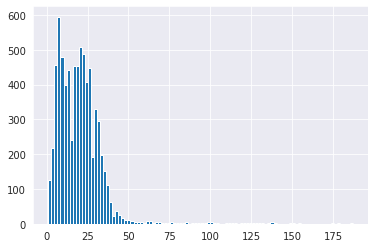

In [14]:
plt.hist([len(s) for s in sentence_tag_list if len(s) < 200], bins = 100)
plt.show()

## Encode input and output.

In [15]:
X = [[word2idx[w[0]] for w in s] for s in sentence_tag_list]
y = [[tag2idx[w[1]] for w in s] for s in sentence_tag_list]

In [16]:
print("X: ", X[0])
print("y: ", y[0])

X:  [4812, 6551, 8802, 8071, 5127, 1671, 8583]
y:  [2, 3, 8, 8, 8, 3, 8]


## Train-Test Split.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True)

In [72]:
print("X_train size: ", len(X_train))
print("X_test size: ", len(X_test))

X_train size:  6579
X_test size:  731


## Sample Neural Network.

###  Sample Parameters.

In [19]:
BATCH_SIZE_SAMPLE = 2
EMBEDDING_SIZE_SAMPLE = 5
VOCAB_SIZE = len(word2idx)
TARGET_SIZE = len(tag2idx)
HIDDEN_SIZE_SAMPLE = 3
STACKED_LAYERS_SAMPLE = 1

###  Sample Dataloader.

In [20]:
class SampleData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [21]:
sample_data = SampleData(X_train, y_train)
sample_loader = DataLoader(sample_data, batch_size=BATCH_SIZE_SAMPLE, collate_fn=lambda x:x)

In [22]:
tl = iter(sample_loader)

i,j = map(list, zip(*next(tl)))

print(i,"\n\n", j, "\n")

[[5870, 6670, 5723, 8071, 77, 4614, 2170, 4523, 2140, 1899, 4614, 7056, 4523, 4614, 8281, 1117, 4614, 2891], [4614, 6747, 3883, 7627, 7081, 5348, 8560, 3766, 4884, 8614, 1899, 185, 3183, 6389, 8614, 8194, 7081, 4614, 8598, 4568, 8405]] 

 [[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 6, 8, 8]] 



### Sample RNN Class.

In [23]:
class ModelGRUSample(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, target_size, stacked_layers):
        super(ModelGRUSample, self).__init__()
        
        self.word_embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_size)
        self.gru = nn.GRU(input_size = embedding_size, hidden_size = hidden_size, batch_first = True, num_layers=stacked_layers)
        self.linear = nn.Linear(in_features = hidden_size, out_features=target_size)
        
    def forward(self, x_batch):
        print("\nList of tensor lengths in a batch: ")
        len_list = list(map(len, x_batch))
        print(len_list)
        
        padded_batch = pad_sequence(x_batch, batch_first=True)
        print("\nPadded X_batch: \n", padded_batch, "\n")

        
        embeds = self.word_embeddings(padded_batch)
        print("\nEmbeddings: \n", embeds, embeds.size(), "\n")

        pack_embeds = pack_padded_sequence(embeds, lengths=len_list, batch_first=True, enforce_sorted=False)
        
        rnn_out, rnn_hidden = self.gru(pack_embeds)
        
        rnn_out_padded = pad_packed_sequence(rnn_out, batch_first=True)
        print("\nPadded RNN output each layer:\n", rnn_out_padded[0])        
        
        linear_out = self.linear(rnn_out_padded[0])
        
        y_out = torch.log_softmax(linear_out, dim = 1)
        print("\nLogSoftmax:\n", y_out)

        
        return y_out

In [24]:
gru_model_sample = ModelGRUSample(embedding_size=EMBEDDING_SIZE_SAMPLE, vocab_size=len(word2idx), hidden_size=HIDDEN_SIZE_SAMPLE, target_size=len(tag2idx), stacked_layers=STACKED_LAYERS_SAMPLE)
print(gru_model_sample)

ModelGRUSample(
  (word_embeddings): Embedding(9341, 5)
  (gru): GRU(5, 3, batch_first=True)
  (linear): Linear(in_features=3, out_features=9, bias=True)
)


In [25]:
with torch.no_grad():
    for batch in sample_loader:
        x_batch, y_batch = map(list, zip(*batch))
        x_batch = [torch.tensor(i) for i in x_batch]
        y_batch = [torch.tensor(i) for i in y_batch]
        
        
        print("X batch: ")
        pprint(x_batch)
        print("\ny batch: ")
        pprint(y_batch)
        
        y_out = gru_model_sample(x_batch)
                        
        _, y_out_tag = torch.max(y_out, dim = 2)
        print("\nY Output Tag: \n", y_out_tag)
        
        print("\nActual Output: ")
        print(y_batch)


        break

X batch: 
[tensor([5870, 6670, 5723, 8071,   77, 4614, 2170, 4523, 2140, 1899, 4614, 7056,
        4523, 4614, 8281, 1117, 4614, 2891]),
 tensor([4614, 6747, 3883, 7627, 7081, 5348, 8560, 3766, 4884, 8614, 1899,  185,
        3183, 6389, 8614, 8194, 7081, 4614, 8598, 4568, 8405])]

y batch: 
[tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
 tensor([8, 8, 8, 3, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 6, 8, 8])]

List of tensor lengths in a batch: 
[18, 21]

Padded X_batch: 
 tensor([[5870, 6670, 5723, 8071,   77, 4614, 2170, 4523, 2140, 1899, 4614, 7056,
         4523, 4614, 8281, 1117, 4614, 2891,    0,    0,    0],
        [4614, 6747, 3883, 7627, 7081, 5348, 8560, 3766, 4884, 8614, 1899,  185,
         3183, 6389, 8614, 8194, 7081, 4614, 8598, 4568, 8405]]) 


Embeddings: 
 tensor([[[ 1.8870, -0.7260, -0.8494,  0.0380,  2.2705],
         [ 0.8295,  0.4259,  0.9367, -1.0954, -1.6446],
         [-0.7786, -0.1885, -1.1264,  1.2179,  1.1586],
         [ 0.1069,  0.8882,

## Actual Neural Network.

### Model Parameters

In [83]:
EPOCHS = 30
BATCH_SIZE = 128
EMBEDDING_SIZE = 256
VOCAB_SIZE = len(word2idx)
TARGET_SIZE = len(tag2idx)
HIDDEN_SIZE = 8
LEARNING_RATE = 0.01
STACKED_LAYERS = 4

### Data Loader.

#### Train loader.

In [84]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [85]:
train_data = TrainData(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=lambda x:x)

#### Test loader.

In [86]:
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [87]:
test_data = TestData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=lambda x:x)

## GRU Model Class.

In [88]:
class ModelGRU(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, target_size, stacked_layers):
        super(ModelGRU, self).__init__()
        
        self.word_embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_size)
        self.gru = nn.GRU(input_size = embedding_size, hidden_size = hidden_size, batch_first = True, num_layers=stacked_layers)
        self.linear = nn.Linear(in_features = hidden_size, out_features=target_size)
        
    def forward(self, x_batch):
        len_list = list(map(len, x_batch))        
        padded_batch = pad_sequence(x_batch, batch_first=True)
    
        embeds = self.word_embeddings(padded_batch)
        
        pack_embeds = pack_padded_sequence(embeds, lengths=len_list, batch_first=True, enforce_sorted=False)
        
        rnn_out, rnn_hidden = self.gru(pack_embeds)
        
        rnn_out_padded = pad_packed_sequence(rnn_out, batch_first=True)
        
        linear_out = self.linear(rnn_out_padded[0])
        
        return linear_out

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [91]:
gru_model = ModelGRU(embedding_size=EMBEDDING_SIZE, vocab_size=len(word2idx), hidden_size=HIDDEN_SIZE, target_size=len(tag2idx), stacked_layers=STACKED_LAYERS)

gru_model.to(device)
print(gru_model)

tag_weights = torch.tensor([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
criterion = nn.CrossEntropyLoss(weight=tag_weights.cuda())

optimizer =  optim.Adam(gru_model.parameters())

ModelGRU(
  (word_embeddings): Embedding(9341, 256)
  (gru): GRU(256, 8, num_layers=4, batch_first=True)
  (linear): Linear(in_features=8, out_features=9, bias=True)
)


## Train the model.

In [92]:
gru_model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for batch in train_loader:
        x_batch, y_batch = map(list, zip(*batch))
        x_batch = [torch.tensor(i).to(device) for i in x_batch]
        y_batch = [torch.tensor(i).to(device) for i in y_batch]
        y_batch = pad_sequence(y_batch, batch_first=True)
        
        y_pred = gru_model(x_batch)
                        
        loss = criterion(y_pred.permute(0, 2, 1), y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 2.00441
Epoch 002: | Loss: 1.63730
Epoch 003: | Loss: 1.45445
Epoch 004: | Loss: 1.38089
Epoch 005: | Loss: 1.34010
Epoch 006: | Loss: 1.27391
Epoch 007: | Loss: 1.16676
Epoch 008: | Loss: 1.08682
Epoch 009: | Loss: 1.04209
Epoch 010: | Loss: 1.00331
Epoch 011: | Loss: 0.97911
Epoch 012: | Loss: 0.96183
Epoch 013: | Loss: 0.94598
Epoch 014: | Loss: 0.93243
Epoch 015: | Loss: 0.92266
Epoch 016: | Loss: 0.92143
Epoch 017: | Loss: 0.91708
Epoch 018: | Loss: 0.92382
Epoch 019: | Loss: 0.92579
Epoch 020: | Loss: 0.93433
Epoch 021: | Loss: 0.93409
Epoch 022: | Loss: 0.92882
Epoch 023: | Loss: 0.94685
Epoch 024: | Loss: 0.93152
Epoch 025: | Loss: 0.93754
Epoch 026: | Loss: 0.95781
Epoch 027: | Loss: 0.92156
Epoch 028: | Loss: 0.96707
Epoch 029: | Loss: 0.94503
Epoch 030: | Loss: 0.95098


## Test the model.

In [93]:
y_out_tags_list = []
with torch.no_grad():        
    for batch in test_loader:
        x_batch, y_batch = map(list, zip(*batch))
        x_batch = [torch.tensor(i).to(device) for i in x_batch]
        y_batch = [torch.tensor(i).to(device) for i in y_batch]
        y_batch = pad_sequence(y_batch, batch_first=True)

    
        y_pred = gru_model(x_batch)
        y_pred_logsoftmax = torch.log_softmax(y_pred, dim = 2)
        _, y_pred_tag = torch.max(y_pred, dim = 2)
        y_out_tags_list.append(y_pred_tag.squeeze(0).cpu().numpy())

In [94]:
print(metrics.flat_classification_report(y_test, y_out_tags_list))

              precision    recall  f1-score   support

           1       0.08      0.85      0.14       639
           2       0.12      0.80      0.21       787
           3       0.04      0.25      0.07       337
           4       0.00      0.00      0.00         1
           6       0.38      0.02      0.04       606
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00     12015

    accuracy                           0.09     14386
   macro avg       0.09      0.27      0.07     14386
weighted avg       0.03      0.09      0.02     14386



/home/akshaj/miniconda3/envs/toothless/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Try out the model.

In [95]:
testl = iter(test_loader)

In [100]:
with torch.no_grad():        
    batch = next(testl)
    x_batch, y_batch = map(list, zip(*batch))
    x_batch = [torch.tensor(i).to(device) for i in x_batch]
    y_batch = [torch.tensor(i).to(device) for i in y_batch]
    y_batch = pad_sequence(y_batch, batch_first=True)


    y_pred = gru_model(x_batch)
    y_pred_logsoftmax = torch.log_softmax(y_pred, dim = 2)
    _, y_pred_tag = torch.max(y_pred, dim = 2)
    
    x_batch = x_batch[0].cpu().numpy()
    y_batch = y_batch[0].cpu().numpy()
    y_pred_tag = y_pred_tag[0].cpu().numpy()
    
    print('{:26}: {:15}: {}\n'.format("Word", "Pred", "Actual"))
    
    for w, pred, actual in zip(x_batch, y_pred_tag, y_batch):
        pprint("{:25}: {:15}: {}".format(words[w.item()], tags[pred], tags[actual.item()]))

Word                      : Pred           : Actual

'there                    : I-PER          : O'
'were                     : I-PER          : O'
'big                      : I-PER          : O'
'buyers                   : I-PER          : O'
'at                       : I-PER          : O'
'the                      : I-PER          : O'
'base                     : I-PER          : O'
'of                       : I-PER          : O'
'where                    : I-PER          : O'
'the                      : I-MISC         : O'
'market                   : I-MISC         : O'
'sold                     : I-MISC         : O'
'to                       : I-MISC         : O'
'and                      : I-MISC         : O'
'when                     : I-PER          : O'
'the                      : I-MISC         : O'
'currency                 : I-MISC         : O'
'got                      : I-MISC         : O'
'bought                   : I-ORG          : O'
'back                     : I-MISC 